
# AMBIENTE

In [23]:
# self.coords = {'Usaquen':[4.73349, -74.0273],
#                     'Chapinero':[4.6453552,-74.0619385],
#                     'Santa fe':[4.63142,-74.0594],
#                     'San Cristobal':[4.5687863,-74.0950182],
#                     'Usme':[4.47067,-74.1261],
#                     'Tunjuelito':[4.58233,-74.1321],
#                     'Bosa':[4.61706,-74.1899],
#                     'Kennedy':[4.6435,  -74.1533],
#                     'Fontibon':[4.6732943,-74.1447464],
#                     'Engativa':[ 4.7086571,-74.109647],
#                     'Suba':[4.7466362,-74.0956029],
#                     'Barrios Unidos':[4.67866, -74.0787]}

In [2]:
#LIbrerias uwu
import copy
import math
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import warnings
import random
from time import sleep
from IPython.display import clear_output
from busqueda import *
from tiempos import *
warnings.filterwarnings('ignore')

C:\Users\k513eq\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
#FUNCIONES UTILES UWU

def haversine(p1, p2):
  phi_1,lambda_1 = p1[0],p1[1]
  phi_2,lambda_2 = p2[0],p2[1]

  R = 6371e3

  delta_phi = abs(phi_1 - phi_2)
  delta_lambda = abs(lambda_1 - lambda_2)

  a = math.sin(math.radians(delta_phi / 2))**2 + math.cos(math.radians(phi_1))*math.cos(math.radians(phi_2))*math.sin(math.radians(delta_lambda / 2))**2
  c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))

  d = (R*c)/1000
  return d

class Vendedor:
    # @Autores: Isabella Martinez Martinez y Estefania Laverde Becerra

    def __init__(self, localidad):
        self.estado_inicial = [localidad]
        self.coords = {'Usaquen':[4.73349, -74.0273],
                    'Chapinero':[4.6453552,-74.0619385],
                    'Santa fe':[4.63142,-74.0594],
                    'Suba':[4.7466362,-74.0956029],
                    'Usme':[4.47067,-74.1261],
                    'Bosa':[4.61706,-74.1899],
                    'Tunjuelito':[4.58233,-74.1321],
                    'San Cristobal':[4.5687863,-74.0950182]}

        self.rutas = {}
        for localidad_1 in self.coords.keys():
            self.rutas[localidad_1] = {}
            for localidad_2 in self.coords.keys():
                if localidad_2 != localidad_1:
                    self.rutas[localidad_1][localidad_2] = haversine(self.coords[localidad_1], self.coords[localidad_2])

        self.localidades = list(self.coords.keys())
        self.df = (pd.DataFrame(self.coords)).transpose()
        self.df.columns = [ 'latitude','longitude']

        self.tk = 'pk.eyJ1IjoiZXN0ZWZhbmlhbGF2ZXJkZSIsImEiOiJjbDZ1emwwbXIxNjlpM2lxOXcybm93enphIn0.lFL91CtkpIqnRmgvnGacZA'
        

    def pintar_estado(self,estado):
        px.set_mapbox_access_token(self.tk)
        fig = px.scatter_mapbox(self.df, 
                            lat = self.df['latitude'],
                            lon = self.df['longitude'],
                            hover_name = list(self.df.index))
        fig.update_traces(marker={'size': 15, 'color':'#a3b18a'})
        fig.update_layout(margin ={'l':0,'t':0,'b':0,'r':0},
                        mapbox = {'zoom': 10},
                        width=900,
                        height=600,)
        
        for i in range(len(estado) - 1):
            long_ = [self.df.loc[estado[i]]['longitude'], self.df.loc[estado[i+1]]['longitude']]
            lati = [self.df.loc[estado[i]]['latitude'], self.df.loc[estado[i+1]]['latitude']]

            fig.add_trace(go.Scattermapbox(mode="markers+lines",
                text = [estado[i], estado[i+1]],
                lon = long_,
                lat = lati,
                marker = {'size': 15, 'color':'#dda15e'}))
        fig.update(layout_showlegend = False)
        fig.show()
        

    def pintar_camino(self, camino):
        # Input: lista con caminos de estado. Pej ['Usaquen','Santa  fe','Usme']
        # Output: figura con el camino
        estado = [camino.pop(0)]
        
        while len(camino) > 0:
            clear_output(wait=True)
            self.pintar_estado(estado)
            sleep(2)
            estado += [camino.pop(0)]
        clear_output(wait=True)
        self.pintar_estado(estado)

    def acciones_aplicables(self, estado):
        # INPUT: localidad en la que se encuentra el agente
        # OUTPUT: Lista con localidades no visitadas
        return [localidad for localidad in self.localidades if localidad not in estado]
    
    def transicion(self,estado, accion):
        # INPUT: estado - localidad en la que se encuentra el agente
            #    accion - desplazamiento
        # OUTPUT: Copia de la lista estado actualizada
        lista = copy.deepcopy(estado)
        lista.append(accion)
        return lista

    def test_objetivo(self, estado):
        """ Verifica si ya fueron visitadas todas las localidades
            Input: estado (lista con el camino)
            Output: Boolean """
        return set(self.localidades) == set(estado)

    def codigo(self, estado):
        """ Actualiza el codigo
            Input: estado (lista con el camino)
            Output: cadena """
        cad = ""
        for i in estado:
            cad = cad + " - " + i
        return cad

    def costo(self, estado, accion):
        """ Peso entre el estado y la accion
            Input: estado (camino actual)
                   accion (desplazamiento)
            Output: Int """
        loc = self.rutas[estado[-1]]
        return loc[accion]

    def obtener_peso(self, localidad_1, localidad_2):
        """ Retorna el peso entre dos localidades
            Input: estado1, estado2, localidades
            Output: Int, distancia entre ambas localidades"""
        loc = self.rutas[localidad_1]
        return loc[localidad_2]

    def distancia_faltante(self,estado):
        suma = 0
        for loc in self.localidades:
            if loc not in estado:
                suma += self.rutas[estado[-1]][loc]
        return suma 

In [4]:
problema = Vendedor('Usaquen')

#METODO: BEST_FIRST

In [5]:
l = best_first_search(problema)
camino = solucion(l)

if l is not None:
    camino_final = problema.estado_inicial + solucion(l) + problema.estado_inicial
    print("Camino a recorrer: ", camino_final)
    print("El peso final es: ", l.costo_camino + problema.obtener_peso(solucion(l)[-1], problema.estado_inicial[0]), 'km')
else:
    print("No hay solución!")

Camino a recorrer:  ['Usaquen', 'Suba', 'Chapinero', 'Santa fe', 'San Cristobal', 'Tunjuelito', 'Bosa', 'Usme', 'Usaquen']
El peso final es:  89.96701496805008 km


In [6]:
problema.pintar_camino(camino_final)

# METODO: BREADTH_FIRST 

In [7]:
l = breadth_first_search(problema)
camino = solucion(l)

if l is not None:
    camino_final = problema.estado_inicial + solucion(l) + problema.estado_inicial
    print("Camino a recorrer: ", camino_final)
    print("El peso final es: ", l.costo_camino + problema.obtener_peso(solucion(l)[-1], problema.estado_inicial[0]), 'km')
else:
    print("No hay solución!")

Camino a recorrer:  ['Usaquen', 'Chapinero', 'Santa fe', 'Suba', 'Usme', 'Bosa', 'Tunjuelito', 'San Cristobal', 'Usaquen']
El peso final es:  105.79436223231653 km


In [8]:
#Pintar solución :D
#problema.pintar_camino(camino_final)

# METODO: DEPTH_FIRST

In [9]:
l = depth_first_search(problema)
camino = solucion(l)

if l is not None:
    camino_final = problema.estado_inicial + solucion(l) + problema.estado_inicial
    print("Camino a recorrer: ", camino_final)
    print("El peso final es: ", l.costo_camino + problema.obtener_peso(solucion(l)[-1], problema.estado_inicial[0]), 'km')
else:
    print("No hay solución!")

Camino a recorrer:  ['Usaquen', 'San Cristobal', 'Tunjuelito', 'Bosa', 'Usme', 'Suba', 'Santa fe', 'Chapinero', 'Usaquen']
El peso final es:  105.79436223231654 km


In [10]:
#Pintar solución :D
# problema.pintar_camino(camino_final)

#METODO: DEPTH_LIMITED

In [11]:
l = depth_limited_search(problema, 10)
camino = solucion(l)

if l is not None:
    camino_final = problema.estado_inicial + solucion(l) + problema.estado_inicial
    print("Camino a recorrer: ", camino_final)
    print("El peso final es: ", l.costo_camino + problema.obtener_peso(solucion(l)[-1], problema.estado_inicial[0]), 'km')
else:
    print("No hay solución!")

Camino a recorrer:  ['Usaquen', 'San Cristobal', 'Tunjuelito', 'Bosa', 'Usme', 'Suba', 'Santa fe', 'Chapinero', 'Usaquen']
El peso final es:  105.79436223231654 km


In [12]:
#Pintar solución :D
# problema.pintar_camino(camino_final)

# METODO ITERATIVE DEEPENING

In [13]:
l = iterative_deepening_search(problema, 100)
camino = solucion(l)

if l is not None:
    camino_final = problema.estado_inicial + solucion(l) + problema.estado_inicial
    print("Camino a recorrer: ", camino_final)
    print("El peso final es: ", l.costo_camino + problema.obtener_peso(solucion(l)[-1], problema.estado_inicial[0]), 'km')
else:
    print("No hay solución!")

Camino a recorrer:  ['Usaquen', 'San Cristobal', 'Tunjuelito', 'Bosa', 'Usme', 'Suba', 'Santa fe', 'Chapinero', 'Usaquen']
El peso final es:  105.79436223231654 km


In [14]:
#Pintar solución :D
# problema.pintar_camino(camino_final)

#A STAR

In [15]:
from types import MethodType

def A_star(problema, f, g=None):
    if g != None:
        problema.costo = MethodType(g, problema)
    s = problema.estado_inicial
    cod = problema.codigo(s)
    nodo = Nodo(s, None, None, 0, cod)
    v = f(s)
    frontera = ListaPrioritaria()
    frontera.push(nodo, v)
    explorados = {}
    explorados[cod] = v
    while not frontera.is_empty():
        nodo = frontera.pop()
        if problema.test_objetivo(nodo.estado):
            return nodo
        for hijo in expand(problema, nodo):
            s = hijo.estado
            cod = problema.codigo(s)
            c = hijo.costo_camino + f(s)
            if (cod not in explorados.keys()) or (c < explorados[cod]):
                frontera.push(hijo, c)
                explorados[cod] = c
    return None

In [16]:
l = A_star(problema, f=problema.distancia_faltante, g=None)

In [17]:
camino = solucion(l)

if l is not None:
    camino_final = problema.estado_inicial + solucion(l) + problema.estado_inicial
    print("Camino a recorrer: ", camino_final)
    print("El peso final es: ", l.costo_camino + problema.obtener_peso(solucion(l)[-1], problema.estado_inicial[0]), 'km')
else:
    print("No hay solución!")

Camino a recorrer:  ['Usaquen', 'Chapinero', 'Santa fe', 'San Cristobal', 'Tunjuelito', 'Bosa', 'Usme', 'Suba', 'Usaquen']
El peso final es:  88.29147019129611 km


In [18]:
problema.pintar_camino(camino_final)

#MOETODO: GREEDY_SEARCH

In [19]:
l = greedy_search(problema, f=problema.distancia_faltante)
camino = solucion(l)

if l is not None:
    camino_final = problema.estado_inicial + solucion(l) + problema.estado_inicial
    print("Camino a recorrer: ", camino_final)
    print("El peso final es: ", l.costo_camino + problema.obtener_peso(solucion(l)[-1], problema.estado_inicial[0]), 'km')
else:
    print("No hay solución!")

Camino a recorrer:  ['Usaquen', 'Tunjuelito', 'Santa fe', 'San Cristobal', 'Chapinero', 'Bosa', 'Usme', 'Suba', 'Usaquen']
El peso final es:  118.2941575519633 km


In [20]:
#Pintar solución :D
problema.pintar_camino(camino_final)

#TIEMPOS UWU

In [21]:
funs = [
    lambda x: breadth_first_search(x),
    lambda x: depth_first_search(x),
    lambda x: depth_limited_search(x,10),
    lambda x: iterative_deepening_search(x, 500),
    lambda x: best_first_search(x),
    lambda x: greedy_search(x, f=x.distancia_faltante),
    lambda x: A_star(x, f=x.distancia_faltante, g = None),
]
nombres = [
    'breadth_first',
    'depth_first',
    'depth_limited',
    'iterative_deepening',
    'best_search', 
    'greedy',
    'A*',
]

#PONERLE EL RANDOM DE CIUDADES :0
viaje = Vendedor('Santa fe')
ciudades = viaje.rutas.keys()

               sum_sq      df            F  PR(>F)
C(Función)  16.258741     6.0  1586.320876     0.0
Residual     2.379555  1393.0          NaN     NaN


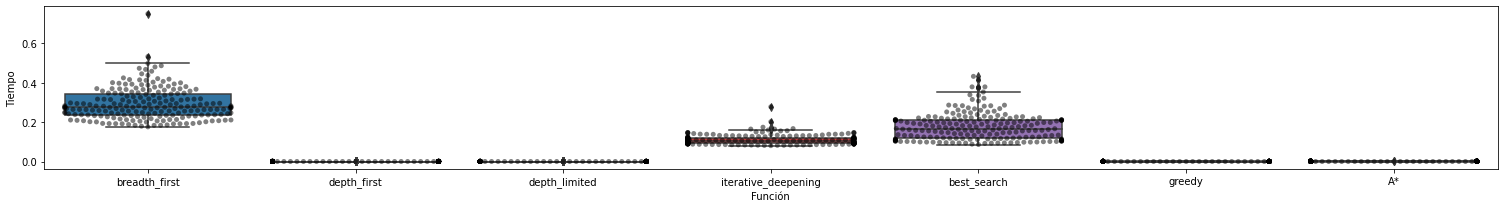

In [22]:
inicio = [random.choice(list(ciudades)) for _ in range(20)]
args = [Vendedor(localidad) for localidad in inicio]

#Comparacion de funciones :D
data = compara_funciones_sobreargumentos(funs=funs, args=args, nombres=nombres)

# Graficando
fig, ax = plt.subplots(1,1, figsize=(3*len(funs),3), tight_layout=True)
sns.boxplot(data=data, x='Función', y='Tiempo')
sns.swarmplot(data=data, x='Función', y='Tiempo', color='black', alpha = 0.5, ax=ax);
# Anova diferencia de medias
model = ols('Tiempo ~ C(Función)', data=data).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

              sum_sq     df           F        PR(>F)
C(Función)  0.000084    3.0  109.723147  1.844513e-59
Residual    0.000203  796.0         NaN           NaN


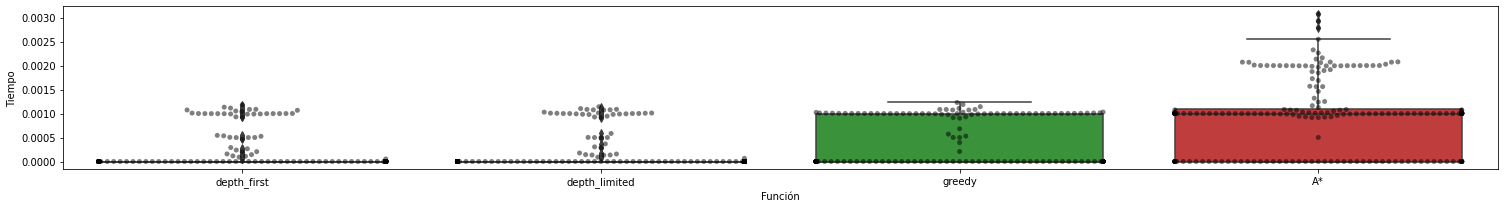

In [29]:
data2 = data[data['Función'].isin(['depth_first', 'depth_limited', 'greedy', 'A*'])]

# Graficando
fig, ax = plt.subplots(1,1, figsize=(3*len(funs),3), tight_layout=True)
sns.boxplot(data=data2, x='Función', y='Tiempo')
sns.swarmplot(data=data2, x='Función', y='Tiempo', color='black', alpha = 0.5, ax=ax);
# Anova diferencia de medias
model = ols('Tiempo ~ C(Función)', data=data2).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

                  sum_sq     df         F    PR(>F)
C(Función)  6.227822e-09    1.0  0.051107  0.821263
Residual    4.849926e-05  398.0       NaN       NaN


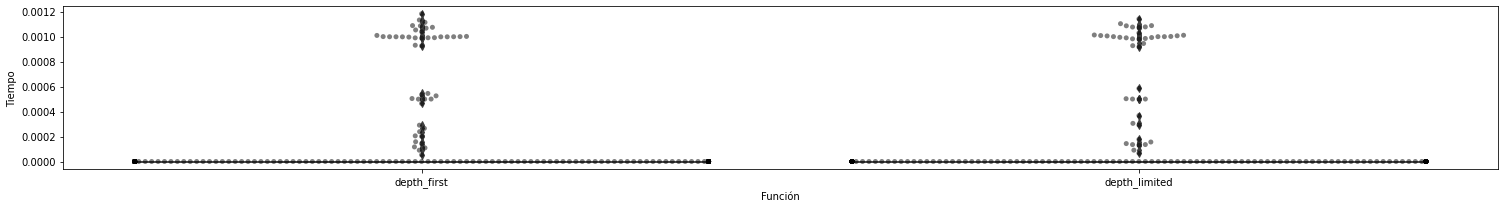

In [30]:
data3 = data[data['Función'].isin(['depth_first', 'depth_limited'])]

# Graficando
fig, ax = plt.subplots(1,1, figsize=(3*len(funs),3), tight_layout=True)
sns.boxplot(data=data3, x='Función', y='Tiempo')
sns.swarmplot(data=data3, x='Función', y='Tiempo', color='black', alpha = 0.5, ax=ax);
# Anova diferencia de medias
model = ols('Tiempo ~ C(Función)', data=data3).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

              sum_sq     df           F        PR(>F)
C(Función)  0.000084    3.0  109.723147  1.844513e-59
Residual    0.000203  796.0         NaN           NaN


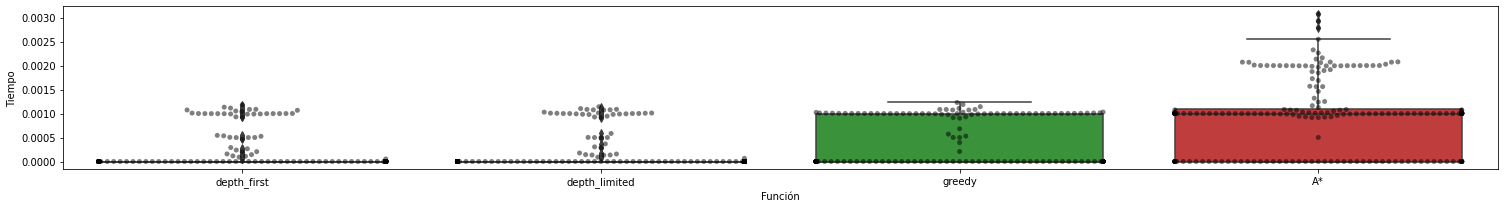

In [31]:
data4 = data[data['Función'].isin(['breadth_first', 'iterative_deepening', 'best_search'])]

# Graficando
fig, ax = plt.subplots(1,1, figsize=(3*len(funs),3), tight_layout=True)
sns.boxplot(data=data4, x='Función', y='Tiempo')
sns.swarmplot(data=data4, x='Función', y='Tiempo', color='black', alpha = 0.5, ax=ax);
# Anova diferencia de medias
model = ols('Tiempo ~ C(Función)', data=data4).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)